# Import Necessary Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Load Data from CSV

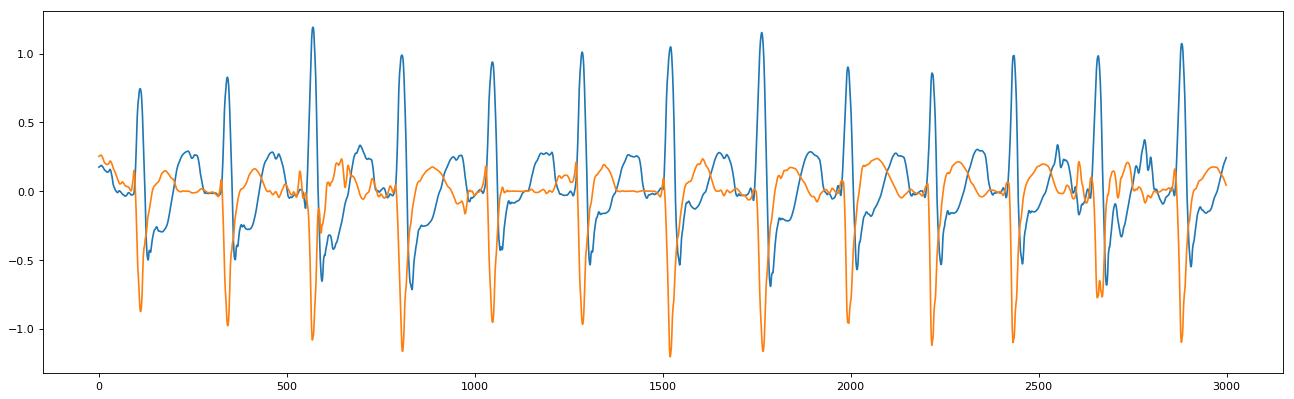

In [2]:
DS1 = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119', '122', '124', 
       '201', '203', '205', '207', '208', '209', '215', '220', '223', '230']

trainingSet_leads = {}
trainingSet_anns = {}
for ds in DS1:
    trainingSet_leads[ds] = pd.read_csv('Cleaned TrainingSet/' + ds + '_lead.csv')
    trainingSet_anns[ds] = pd.read_csv('Cleaned TrainingSet/' + ds + '_ann.csv')

# 测试读取情况
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(trainingSet_leads['109'][:3000])
plt.show()

# Heartbeat Annotation

In [3]:
N = ['N', 'L', 'R', 'e', 'j']
SVEB = ['A', 'a', 'J', 'S']
VEB = ['V', 'E']
F = ['F']
Q = ['P', 'f', 'U']
Non_beat_anns = ['[', ']', '!', 'x', '(', ')', 'p', 't', 'u', '`', '~', '^', '|', '+', 's', 'T', '*', 'D', '=', '"', '@']

# Heatbeat Segmentation

For each heartbeat knowing the R location, we take samples from the interval of 250 ms before R peak and 400 ms after R peak, i.e. total 0.65 s of each heartbeat. That is, 90 samples before R peak and 144 samples after R peak.

In [4]:
Hbs = {}
for ds in DS1:
    lead0 = trainingSet_leads[ds]['lead0']
    lead1 = trainingSet_leads[ds]['lead1']
    hbs0 = []
    hbs1 = []
    anns = []
    annIdxs = []
    for row in trainingSet_anns[ds].itertuples():
        if row[2] in Non_beat_anns:
            continue
        elif row[1] < 91:
            continue
        elif row[1] + 144 > len(lead0):
            continue
        else:
            anns.append(row[2])
            annIdxs.append(row[1] - 1)
            hbs0.append(lead0[row[1] - 91: row[1] + 144])
            hbs1.append(lead1[row[1] - 91: row[1] + 144])
    Hbs[ds] = pd.DataFrame({'lead0': hbs0, 'lead1': hbs1, 'ann': anns, 'annIdx': annIdxs})

In [5]:
Hbs['230'].head(10)

,ann,annIdx,lead0,lead1
0,N,348,258 -0.042078 259 -0.043460 260 -0.04448...,258 -0.039954 259 -0.041158 260 -0.04203...
1,N,615,525 -0.048473 526 -0.053367 527 -0.05693...,525 -0.046625 526 -0.048911 527 -0.05015...
2,N,879,789 -0.060152 790 -0.062797 791 -0.06...,789 -0.033493 790 -0.037047 791 -0.03...
3,N,1137,1047 -0.076912 1048 -0.085018 1049 -0.09...,1047 -0.022912 1048 -0.027599 1049 -0.03...
4,N,1399,1309 0.011639 1310 0.011823 1311 0.01...,1309 -0.031675 1310 -0.035828 1311 -0.03...
5,N,1665,1575 -0.005642 1576 -0.007687 1577 -0.01...,1575 -0.029827 1576 -0.030038 1577 -0.03...
6,N,1925,1835 -0.094674 1836 -0.098730 1837 -0.10...,1835 -0.037774 1836 -0.039638 1837 -0.04...
7,N,2198,2108 -0.049983 2109 -0.056472 2110 -0.06...,2108 -0.044898 2109 -0.044204 2110 -0.04...
8,N,2466,2376 -0.017122 2377 -0.022907 2378 -0.02...,2376 -0.043877 2377 -0.042901 2378 -0.04...
9,N,2725,2635 0.003155 2636 0.006594 2637 0.01...,2635 -0.052277 2636 -0.056282 2637 -0.06...


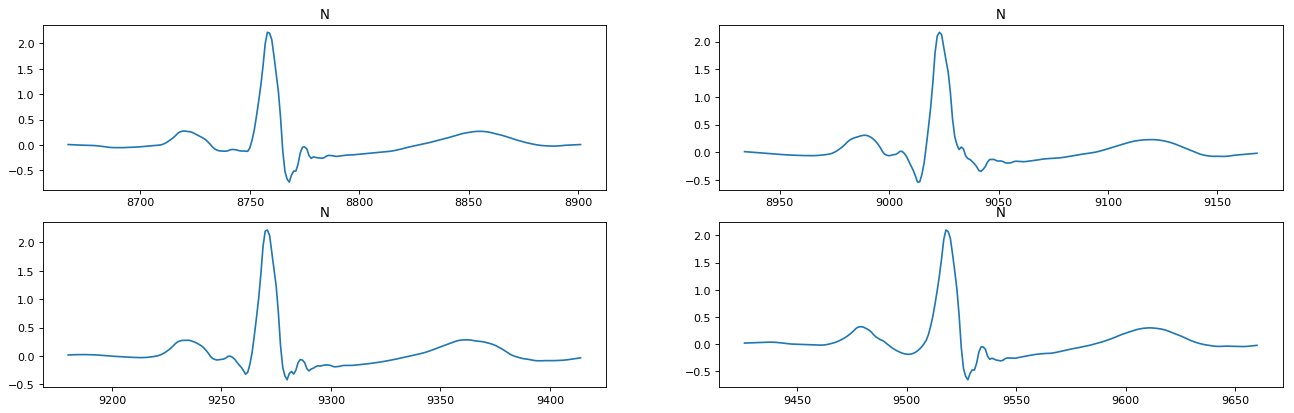

In [6]:
hb_num = 26
hb_set = '106'
plt.figure(figsize=(20, 6), dpi=80)
p1 = plt.subplot(221)
p1.plot(Hbs[hb_set]['lead0'][hb_num])
p1.set_title(Hbs[hb_set]['ann'][hb_num])
p2 = plt.subplot(222)
p2.plot(Hbs[hb_set]['lead0'][hb_num+1])
p2.set_title(Hbs[hb_set]['ann'][hb_num+1])
p3 = plt.subplot(223)
p3.plot(Hbs[hb_set]['lead0'][hb_num+2])
p3.set_title(Hbs[hb_set]['ann'][hb_num+2])
p4 = plt.subplot(224)
p4.plot(Hbs[hb_set]['lead0'][hb_num+3])
p4.set_title(Hbs[hb_set]['ann'][hb_num+3])
plt.show()

# R-Peak Correction and Computing RR Intervals

### R-Peak Correction

In [62]:
def R_Correction(beat, spacing = 30):
    length = beat.size
    x = np.zeros(length + 2 * spacing)
    x[: spacing] = float("-inf")
    x[-spacing: ] = float("-inf")
    x[spacing: spacing + length] = beat
    r_candidate = np.zeros(length)
    r_candidate[:] = True
    for s in range(spacing):
        start = spacing - s - 1
        h_b = x[start: start + length]  # before
        start = spacing
        h_c = x[start: start + length]  # central
        start = spacing + s + 1
        h_a = x[start: start + length]  # after
        r_candidate = np.logical_and(r_candidate, np.logical_and(h_c > h_b, h_c > h_a))
    r_idx = np.argwhere(r_candidate)
    r_idx = r_idx.reshape(r_idx.size)
    return r_idx

In [63]:
Refined_Hbs = {}
for ds in DS1:
    lead0 = trainingSet_leads[ds]['lead0']
    lead1 = trainingSet_leads[ds]['lead1']
    hbs0 = []
    hbs1 = []
    anns = []
    annIdxs = []
    for i in range(len(Hbs[ds])):
        beat = Hbs[ds]['lead0'][i]
        ann = Hbs[ds]['ann'][i]
        start = list(Hbs[ds]['lead0'][i].index)[0]
        r_idxs = R_Correction(beat, spacing = 80)
        r_candidates = list(map(lambda x: Hbs[ds]['lead0'][i][x+start], list(r_idxs)))
        r_index = r_idxs[r_candidates.index(max(r_candidates))] + start
        if r_index < 91:
            continue
        elif r_index + 144 > len(lead0):
            continue
        else:
            anns.append(ann)
            annIdxs.append(r_index)
            hbs0.append(lead0[r_index - 91: r_index + 144])
            hbs1.append(lead1[r_index - 91: r_index + 144])
    Refined_Hbs[ds] = pd.DataFrame({'lead0': hbs0, 'lead1': hbs1, 'ann': anns, 'annIdx': annIdxs})

In [64]:
Refined_Hbs['230'].head(10)

,ann,annIdx,lead0,lead1
0,N,350,259 -0.043460 260 -0.044482 261 -0.04514...,259 -0.041158 260 -0.042034 261 -0.04259...
1,N,615,524 -0.042483 525 -0.048473 526 -0.05336...,524 -0.043479 525 -0.046625 526 -0.04891...
2,N,878,787 -0.050956 788 -0.055622 789 -0.06...,787 -0.024303 788 -0.028737 789 -0.03...
3,N,1136,1045 -0.056543 1046 -0.067832 1047 -0.07...,1045 -0.014094 1046 -0.018406 1047 -0.02...
4,N,1399,1308 0.011069 1309 0.011639 1310 0.01...,1308 -0.027278 1309 -0.031675 1310 -0.03...
5,N,1664,1573 -0.002879 1574 -0.004087 1575 -0.00...,1573 -0.029702 1574 -0.029640 1575 -0.02...
6,N,1926,1835 -0.094674 1836 -0.098730 1837 -0.10...,1835 -0.037774 1836 -0.039638 1837 -0.04...
7,N,2198,2107 -0.044087 2108 -0.049983 2109 -0.05...,2107 -0.045407 2108 -0.044898 2109 -0.04...
8,N,2467,2376 -0.017122 2377 -0.022907 2378 -0.02...,2376 -0.043877 2377 -0.042901 2378 -0.04...
9,N,2726,2635 0.003155 2636 0.006594 2637 0.01...,2635 -0.052277 2636 -0.056282 2637 -0.06...


### refine前后对比

ann:  {'V', 'N'}
refined heartbeats amount:  2255


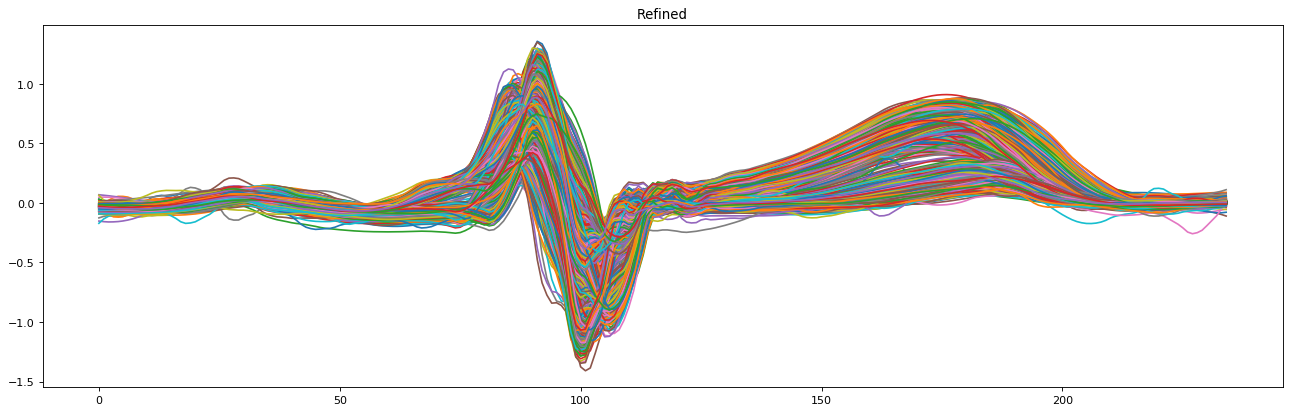

original heartbeats amount:  2255


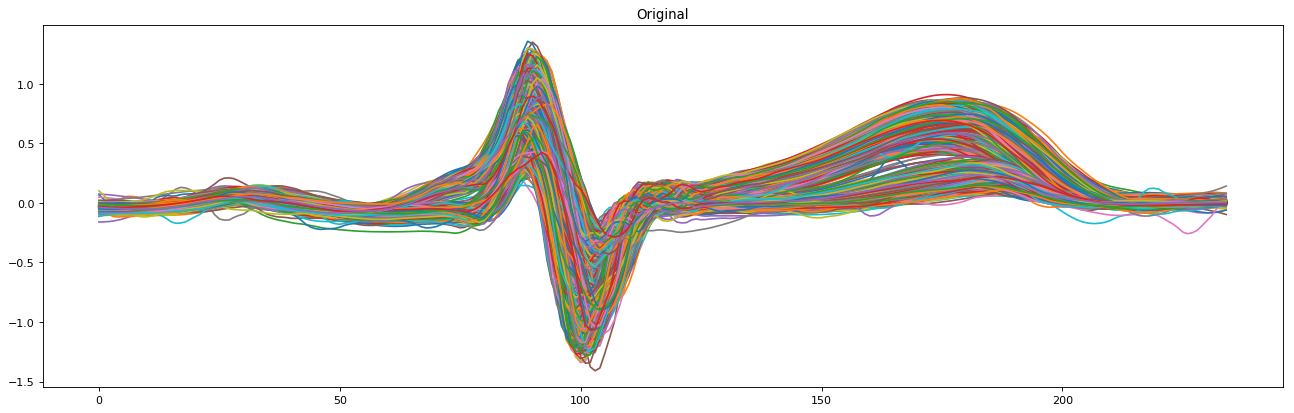

In [69]:
ds = '230'
print('ann: ', set(Refined_Hbs[ds]['ann']))
print('refined heartbeats amount: ', len(Refined_Hbs[ds]))
plt.figure(figsize=(20, 6), dpi=80)
plt.title('Refined')
for i in range(len(Refined_Hbs[ds]) - 1000):
    if Refined_Hbs[ds]['ann'][i] in N:
        beat = Refined_Hbs[ds]['lead1'][i]
        temp = pd.Series(list(beat))
        plt.plot(temp)
plt.show()

print('original heartbeats amount: ', len(Hbs[ds]))
plt.figure(figsize=(20, 6), dpi=80)
plt.title('Original')
for i in range(len(Hbs[ds]) - 1000):
    if Hbs[ds]['ann'][i] in N:
        beat = Hbs[ds]['lead1'][i]
        temp = pd.Series(list(beat))
        plt.plot(temp)
plt.show()

### Computing RR Interval

In [11]:
for ds in DS1:
    dsLast = len(Refined_Hbs[ds]['annIdx']) - 1
    preRR = [np.NAN]
    postRR = [Refined_Hbs[ds]['annIdx'][1] - Refined_Hbs[ds]['annIdx'][0]]
    for l in range(1, dsLast):
        preRR.append(Refined_Hbs[ds]['annIdx'][l] - Refined_Hbs[ds]['annIdx'][l-1])
        postRR.append(Refined_Hbs[ds]['annIdx'][l+1] - Refined_Hbs[ds]['annIdx'][l])
    preRR.append(Refined_Hbs[ds]['annIdx'][dsLast] - Refined_Hbs[ds]['annIdx'][dsLast-1])
    postRR.append(np.NAN)
    Refined_Hbs[ds]['preRR'] = preRR
    Refined_Hbs[ds]['postRR'] = postRR

In [12]:
Refined_Hbs['108'].head(10)

,ann,annIdx,lead0,lead1,preRR,postRR
0,N,366,275 -0.062299 276 -0.062376 277 -0.06205...,275 0.001386 276 0.001031 277 0.00062...,NaN,349.0
1,N,715,624 -0.053418 625 -0.054135 626 -0.05513...,624 0.000157 625 -0.001991 626 -0.00420...,349.0,362.0
2,N,1077,986 -0.051930 987 -0.049631 988 -0.04...,986 -0.014311 987 -0.013969 988 -0.01...,362.0,342.0
3,N,1419,1328 -0.057501 1329 -0.058441 1330 -0.05...,1328 0.027023 1329 0.023356 1330 0.02...,342.0,330.0
4,N,1749,1658 -0.109180 1659 -0.106105 1660 -0.09...,1658 0.005357 1659 0.005139 1660 0.00...,330.0,337.0
5,N,2086,1995 -0.022175 1996 -0.023056 1997 -0.02...,1995 0.028196 1996 0.025417 1997 0.02...,337.0,352.0
6,N,2438,2347 -0.056398 2348 -0.052990 2349 -0.04...,2347 -0.005805 2348 -0.005122 2349 -0.00...,352.0,375.0
7,N,2813,2722 -0.051266 2723 -0.049029 2724 -0.04...,2722 -0.003673 2723 -0.003997 2724 -0.00...,375.0,347.0
8,N,3160,3069 -0.038004 3070 -0.040431 3071 -0.04...,3069 0.004253 3070 0.003297 3071 0.00...,347.0,357.0
9,N,3517,3426 -0.048248 3427 -0.048362 3428 -0.04...,3426 -0.003751 3427 -0.005334 3428 -0.00...,357.0,334.0


# Average Normal Beat in Lead0

In [13]:
MedianNormalBeat = pd.DataFrame()
MeanNormalBeat = pd.DataFrame()
MeanNormalStd = pd.DataFrame()
for ds in DS1:
    N_DF = pd.DataFrame()
    for i in range(len(Refined_Hbs[ds])):
        if Refined_Hbs[ds]['ann'][i] in N:
            beat = Refined_Hbs[ds]['lead0'][i]
            temp = pd.Series(list(beat))
            N_DF['beat_'+str(i)] = temp
    MedianNormalBeat[ds] = N_DF.median(axis=1)
    MeanNormalBeat[ds] = N_DF.mean(axis=1)
    MeanNormalStd[ds] = N_DF.std(axis=1)

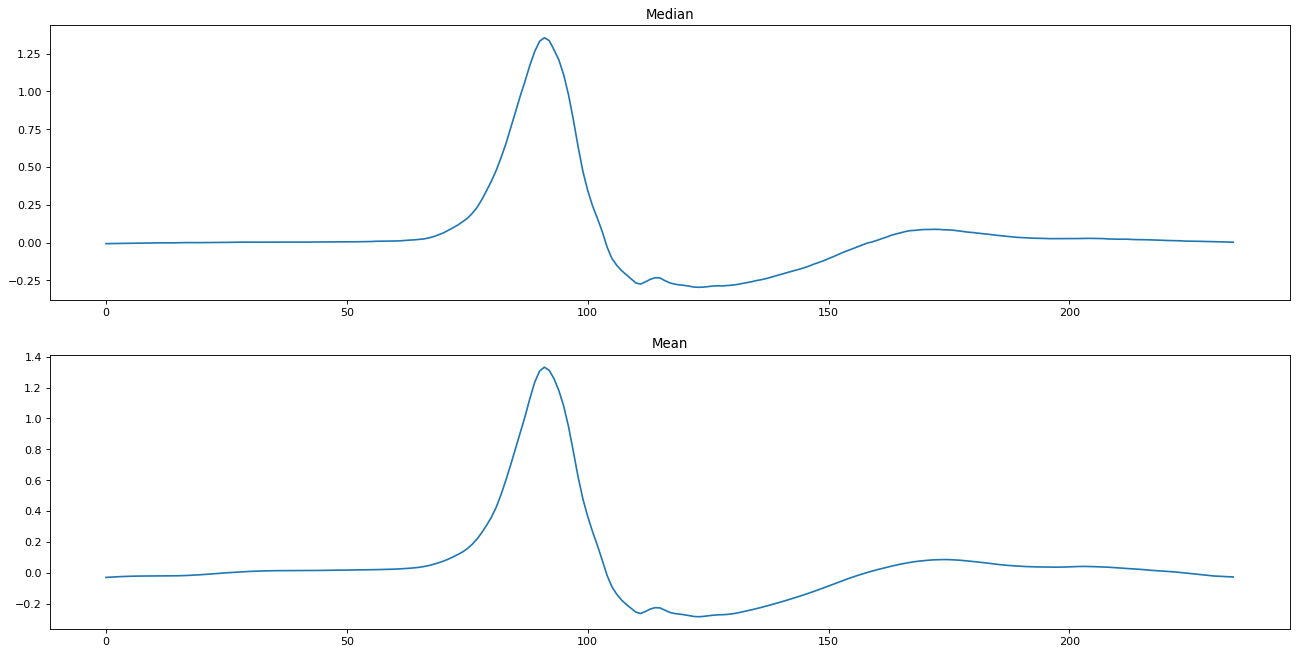

In [14]:
# beware of 108, 114, 118, 207
ds = '203'
plt.figure(figsize=(20, 10), dpi=80)
p1 = plt.subplot(211)
p1.plot(MedianNormalBeat[ds])
p1.set_title('Median')
p2 = plt.subplot(212)
p2.plot(MeanNormalBeat[ds])
p2.set_title('Mean')
plt.show()

# Skewness and Kurtosis Calculation

In [15]:
for ds in DS1:
    dsLength = len(Refined_Hbs[ds]['annIdx'])
    skewness_0 = []
    kurtosis_0 = []
    skewness_1 = []
    kurtosis_1 = []
    for l in range(0, dsLength):
        skewness_0.append(Refined_Hbs[ds]['lead0'][l].skew())
        skewness_1.append(Refined_Hbs[ds]['lead1'][l].skew())
        kurtosis_0.append(Refined_Hbs[ds]['lead0'][l].kurt())
        kurtosis_1.append(Refined_Hbs[ds]['lead1'][l].kurt())
    Refined_Hbs[ds]['skewness_0'] = skewness_0
    Refined_Hbs[ds]['skewness_1'] = skewness_1
    Refined_Hbs[ds]['kurtosis_0'] = kurtosis_0
    Refined_Hbs[ds]['kurtosis_1'] = kurtosis_1

In [16]:
Refined_Hbs['108'].head(10)

,ann,annIdx,lead0,lead1,preRR,postRR,skewness_0,skewness_1,kurtosis_0,kurtosis_1
0,N,366,275 -0.062299 276 -0.062376 277 -0.06205...,275 0.001386 276 0.001031 277 0.00062...,NaN,349.0,-1.659362,-2.517173,4.091169,5.234609
1,N,715,624 -0.053418 625 -0.054135 626 -0.05513...,624 0.000157 625 -0.001991 626 -0.00420...,349.0,362.0,-1.750123,-2.413280,4.320052,5.124249
2,N,1077,986 -0.051930 987 -0.049631 988 -0.04...,986 -0.014311 987 -0.013969 988 -0.01...,362.0,342.0,-1.694983,-2.227622,3.974251,4.094720
3,N,1419,1328 -0.057501 1329 -0.058441 1330 -0.05...,1328 0.027023 1329 0.023356 1330 0.02...,342.0,330.0,-1.781687,-2.346193,4.386415,4.884538
4,N,1749,1658 -0.109180 1659 -0.106105 1660 -0.09...,1658 0.005357 1659 0.005139 1660 0.00...,330.0,337.0,-1.655679,-2.518015,3.024853,5.807601
5,N,2086,1995 -0.022175 1996 -0.023056 1997 -0.02...,1995 0.028196 1996 0.025417 1997 0.02...,337.0,352.0,-1.881155,-2.246919,4.244343,4.733518
6,N,2438,2347 -0.056398 2348 -0.052990 2349 -0.04...,2347 -0.005805 2348 -0.005122 2349 -0.00...,352.0,375.0,-1.652983,-2.045129,3.302639,3.465220
7,N,2813,2722 -0.051266 2723 -0.049029 2724 -0.04...,2722 -0.003673 2723 -0.003997 2724 -0.00...,375.0,347.0,-1.804720,-2.194016,3.868735,4.015808
8,N,3160,3069 -0.038004 3070 -0.040431 3071 -0.04...,3069 0.004253 3070 0.003297 3071 0.00...,347.0,357.0,-1.918706,-2.306657,4.209875,4.830357
9,N,3517,3426 -0.048248 3427 -0.048362 3428 -0.04...,3426 -0.003751 3427 -0.005334 3428 -0.00...,357.0,334.0,-1.669279,-2.238116,3.737277,4.346405


# DWT-based Features

In [17]:
wavelet = pywt.Wavelet('haar')
for ds in DS1:
    dsLength = len(Refined_Hbs[ds]['annIdx'])
    cA7_lead0 = []
    cD7_lead0 = []
    cD6_lead0 = []
    cD5_lead0 = []
    cD4_lead0 = []
    cD3_lead0 = []
    cD2_lead0 = []
    cD1_lead0 = []
    
    cA7_lead1 = []
    cD7_lead1 = []
    cD6_lead1 = []
    cD5_lead1 = []
    cD4_lead1 = []
    cD3_lead1 = []
    cD2_lead1 = []
    cD1_lead1 = []
    
    for l in range(0, dsLength):
        beat = list(Refined_Hbs[ds]['lead0'][l])
        coffs = pywt.wavedec(beat, wavelet, mode='symmetric', level=7)
        cA7_lead0.append(list(coffs[0]))
        cD7_lead0.append(list(coffs[1]))
        cD6_lead0.append(list(coffs[2]))
        cD5_lead0.append(list(coffs[3]))
        cD4_lead0.append(list(coffs[4]))
        cD3_lead0.append(list(coffs[5]))
        cD2_lead0.append(list(coffs[6]))
        cD1_lead0.append(list(coffs[7]))
        
        beat = list(Refined_Hbs[ds]['lead1'][l])
        coffs = pywt.wavedec(beat, wavelet, mode='symmetric', level=7)
        cA7_lead1.append(list(coffs[0]))
        cD7_lead1.append(list(coffs[1]))
        cD6_lead1.append(list(coffs[2]))
        cD5_lead1.append(list(coffs[3]))
        cD4_lead1.append(list(coffs[4]))
        cD3_lead1.append(list(coffs[5]))
        cD2_lead1.append(list(coffs[6]))
        cD1_lead1.append(list(coffs[7]))
    
    Refined_Hbs[ds]['cA7_0'] = cA7_lead0
    Refined_Hbs[ds]['cD7_0'] = cD7_lead0
    Refined_Hbs[ds]['cD6_0'] = cD6_lead0
    Refined_Hbs[ds]['cD5_0'] = cD5_lead0
    Refined_Hbs[ds]['cD4_0'] = cD4_lead0
    Refined_Hbs[ds]['cD3_0'] = cD3_lead0
    Refined_Hbs[ds]['cD2_0'] = cD2_lead0
    Refined_Hbs[ds]['cD1_0'] = cD1_lead0
    
    Refined_Hbs[ds]['cA7_1'] = cA7_lead1
    Refined_Hbs[ds]['cD7_1'] = cD7_lead1
    Refined_Hbs[ds]['cD6_1'] = cD6_lead1
    Refined_Hbs[ds]['cD5_1'] = cD5_lead1
    Refined_Hbs[ds]['cD4_1'] = cD4_lead1
    Refined_Hbs[ds]['cD3_1'] = cD3_lead1
    Refined_Hbs[ds]['cD2_1'] = cD2_lead1
    Refined_Hbs[ds]['cD1_1'] = cD1_lead1

In [30]:
Refined_Hbs['108'].head(1)

,ann,annIdx,lead0,lead1,preRR,postRR,skewness_0,skewness_1,kurtosis_0,kurtosis_1,...,cD2_0,cD1_0,cA7_1,cD7_1,cD6_1,cD5_1,cD4_1,cD3_1,cD2_1,cD1_1
0,N,366,275 -0.062299 276 -0.062376 277 -0.06205...,275 0.001386 276 0.001031 277 0.00062...,NaN,349.0,-1.659362,-2.517173,4.091169,5.234609,...,"[-0.000366936068323, -0.000336346408043, -0.00...","[5.40088479133e-05, -0.000120026582529, -6.995...","[0.169885890371, -1.54735685667]","[-0.174630603452, -3.27640669747]","[0.00328602605249, 0.0851133593558, -1.1589900...","[-0.0185472744616, -0.0138471009017, -0.047815...","[0.0111181123525, -0.00647952300216, -0.001205...","[0.00365501538312, 0.000343156311651, -0.00620...","[0.000848000515287, 0.00169419878951, 0.002278...","[0.000251013565813, 0.000370525579305, 0.00052..."


In [19]:
list(Refined_Hbs['108'].columns.values)

['ann',
 'annIdx',
 'lead0',
 'lead1',
 'preRR',
 'postRR',
 'skewness_0',
 'skewness_1',
 'kurtosis_0',
 'kurtosis_1',
 'cA7_0',
 'cD7_0',
 'cD6_0',
 'cD5_0',
 'cD4_0',
 'cD3_0',
 'cD2_0',
 'cD1_0',
 'cA7_1',
 'cD7_1',
 'cD6_1',
 'cD5_1',
 'cD4_1',
 'cD3_1',
 'cD2_1',
 'cD1_1']

# 把lead0和lead1分成2个数据集

In [20]:
Refined_Hbs_lead0 = {}
Refined_Hbs_lead1 = {}

for ds in DS1:
    Refined_Hbs_lead0[ds] = pd.DataFrame({
        'ann': Refined_Hbs[ds]['ann'],
        'annIdx': Refined_Hbs[ds]['annIdx'],
        'beat': Refined_Hbs[ds]['lead0'],
        'preRR': Refined_Hbs[ds]['preRR'],
        'postRR': Refined_Hbs[ds]['postRR'],
        'skewness': Refined_Hbs[ds]['skewness_0'],
        'kurtosis': Refined_Hbs[ds]['kurtosis_0'],
        'cA7': Refined_Hbs[ds]['cA7_0'],
        'cD7': Refined_Hbs[ds]['cD7_0'],
        'cD6': Refined_Hbs[ds]['cD6_0'],
        'cD5': Refined_Hbs[ds]['cD5_0'],
        'cD4': Refined_Hbs[ds]['cD4_0'],
        'cD3': Refined_Hbs[ds]['cD3_0'],
        'cD2': Refined_Hbs[ds]['cD2_0'],
        'cD1': Refined_Hbs[ds]['cD1_0'],
    })
    
    Refined_Hbs_lead1[ds] = pd.DataFrame({
        'ann': Refined_Hbs[ds]['ann'],
        'annIdx': Refined_Hbs[ds]['annIdx'],
        'beat': Refined_Hbs[ds]['lead1'],
        'preRR': Refined_Hbs[ds]['preRR'],
        'postRR': Refined_Hbs[ds]['postRR'],
        'skewness': Refined_Hbs[ds]['skewness_1'],
        'kurtosis': Refined_Hbs[ds]['kurtosis_1'],
        'cA7': Refined_Hbs[ds]['cA7_1'],
        'cD7': Refined_Hbs[ds]['cD7_1'],
        'cD6': Refined_Hbs[ds]['cD6_1'],
        'cD5': Refined_Hbs[ds]['cD5_1'],
        'cD4': Refined_Hbs[ds]['cD4_1'],
        'cD3': Refined_Hbs[ds]['cD3_1'],
        'cD2': Refined_Hbs[ds]['cD2_1'],
        'cD1': Refined_Hbs[ds]['cD1_1'],
    })


In [21]:
Refined_Hbs_lead0['108'].head(1)

,ann,annIdx,beat,cA7,cD1,cD2,cD3,cD4,cD5,cD6,cD7,kurtosis,postRR,preRR,skewness
0,N,366,275 -0.062299 276 -0.062376 277 -0.06205...,"[0.33745570762, -0.830931628084]","[5.40088479133e-05, -0.000120026582529, -6.995...","[-0.000366936068323, -0.000336346408043, -0.00...","[-0.000574811957378, -0.00756334814559, -0.016...","[-0.00973819221191, -0.0482934427592, -0.00896...","[-0.0896986711747, -0.0696928398024, -0.439675...","[-0.202434103875, 0.654913260104, 0.6721918732...","[-0.54512202865, -1.28998335578]",4.091169,349.0,NaN,-1.659362


# Save Extracted Feature to CSV

In [22]:
# 为了处理 beat（series类型）无法正确存在csv里的情况
for ds in DS1:
    beatValues = []
    beatIndexs = []
    for i in range(len(Refined_Hbs_lead0[ds]['beat'])):
        beatValues.append(list(Refined_Hbs_lead0[ds]['beat'][i].values))
        beatIndexs.append(list(Refined_Hbs_lead0[ds]['beat'][i].index))
    Refined_Hbs_lead0[ds]['beatValues'] = beatValues
    Refined_Hbs_lead0[ds]['beatIndex'] = beatIndexs
    
    beatValues = []
    beatIndexs = []
    for i in range(len(Refined_Hbs_lead1[ds]['beat'])):
        beatValues.append(list(Refined_Hbs_lead1[ds]['beat'][i].values))
        beatIndexs.append(list(Refined_Hbs_lead1[ds]['beat'][i].index))
    Refined_Hbs_lead1[ds]['beatValues'] = beatValues
    Refined_Hbs_lead1[ds]['beatIndex'] = beatIndexs

In [23]:
for ds in DS1:
    Refined_Hbs_lead0[ds].to_csv('Extracted Features/DS1/' + ds + '_lead0.csv', index=False)
    Refined_Hbs_lead1[ds].to_csv('Extracted Features/DS1/' + ds + '_lead1.csv', index=False)

In [24]:
testReadData = pd.read_csv('Extracted Features/DS1/' + '108' + '_lead0.csv')
testReadData.head(1)

,ann,annIdx,beat,cA7,cD1,cD2,cD3,cD4,cD5,cD6,cD7,kurtosis,postRR,preRR,skewness,beatValues,beatIndex
0,N,366,275 -0.062299\r\n276 -0.062376\r\n277 -0...,"[0.33745570761985472, -0.83093162808364807]","[5.4008847913317171e-05, -0.000120026582529485...","[-0.00036693606832250564, -0.00033634640804349...","[-0.00057481195737782431, -0.00756334814559038...","[-0.0097381922119106068, -0.048293442759207147...","[-0.089698671174726088, -0.06969283980235158, ...","[-0.20243410387472038, 0.65491326010384721, 0....","[-0.5451220286495182, -1.2899833557781271]",4.091169,349.0,NaN,-1.659362,"[-0.062299233406144815, -0.062375613451351973,...","[275, 276, 277, 278, 279, 280, 281, 282, 283, ..."


# Experiment - Clustering

检查各个心跳类别在RR Interval特征上的分布情况

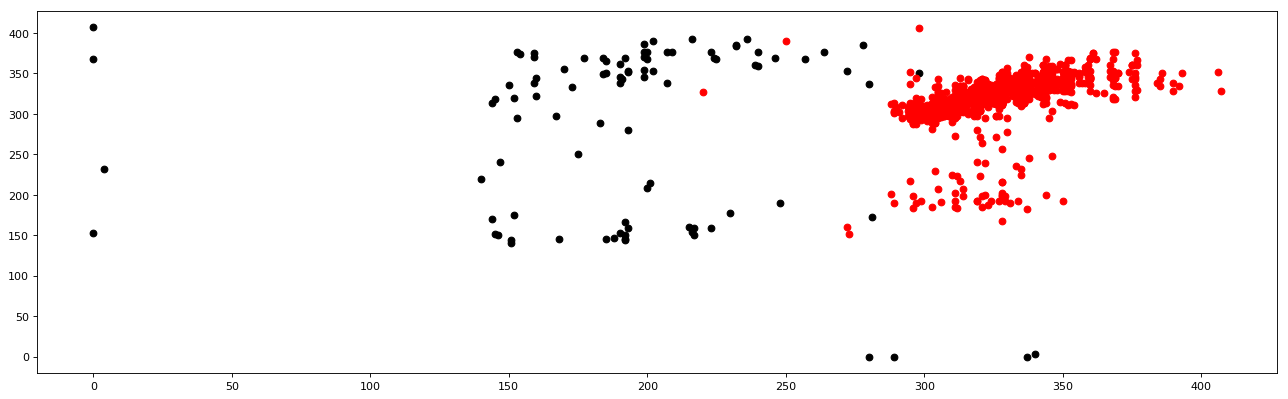

In [25]:
ds = '220'
mark = ['or', 'ob', 'og', 'ok', '^r', '+r', 'sr', 'dr', '<r', 'pr']

featureCols = []
beatIdxs = []
for i in range(1, len(Refined_Hbs[ds]['ann'])-1):
    featureCols.append([Refined_Hbs[ds]['preRR'][i], Refined_Hbs[ds]['postRR'][i]])
    beatIdxs.append(i)
    
plt.figure(figsize=(20, 6), dpi=80)
for i, features in enumerate(featureCols):
    color = mark[7]
    if Refined_Hbs[ds]['ann'][beatIdxs[i]] in N:
        color = mark[0]
    elif Refined_Hbs[ds]['ann'][beatIdxs[i]] in VEB:
        color = mark[1]
    elif Refined_Hbs[ds]['ann'][beatIdxs[i]] in SVEB:
        color = mark[3]
    plt.plot(features[0], features[1], color)
plt.show()

检查各个心跳类别在skewness和kurtosis特征上的分布情况

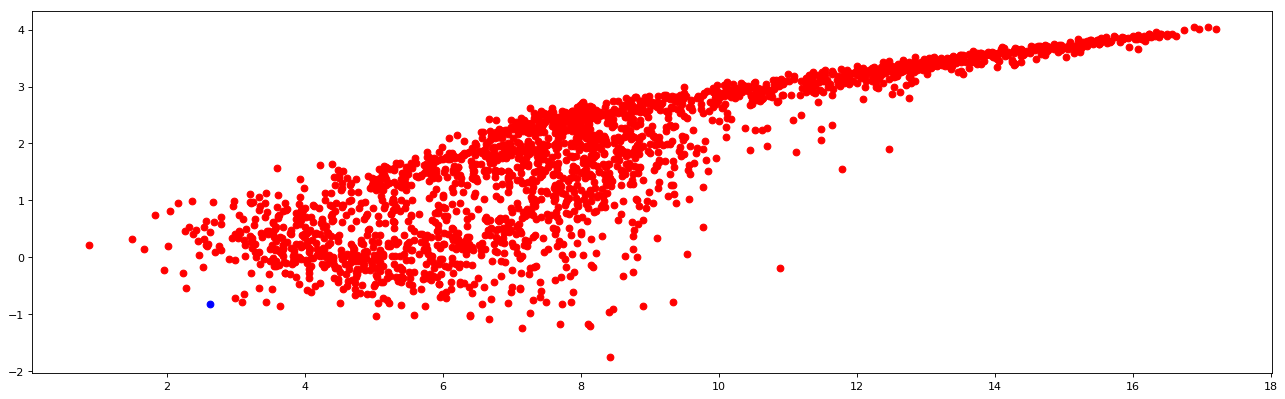

In [26]:
dsCol = ['230']
mark = ['or', 'ob', 'og', 'ok', '^r', '+r', 'sr', 'dr', '<r', 'pr']

featureCols = {}
beatIdxs = {}
for ds in dsCol:
    featureCols[ds] = []
    beatIdxs[ds] = []
    for i in range(1, len(Refined_Hbs[ds]['ann'])-1):
        featureCols[ds].append([Refined_Hbs[ds]['kurtosis_0'][i], Refined_Hbs[ds]['skewness_0'][i]])
        beatIdxs[ds].append(i)
    
plt.figure(figsize=(20, 6), dpi=80)
for ds in dsCol:
    for i, features in enumerate(featureCols[ds]):
        color = mark[7]
        if Refined_Hbs[ds]['ann'][beatIdxs[ds][i]] in N:
            color = mark[0]  # 红色圆点
        elif Refined_Hbs[ds]['ann'][beatIdxs[ds][i]] in VEB:
            color = mark[1]  # 蓝色圆点
        elif Refined_Hbs[ds]['ann'][beatIdxs[ds][i]] in SVEB:
            color = mark[3] # 黑色圆点
        plt.plot(features[0], features[1], color)
plt.show()

综上所述，RR Interval对S类周期异常的分类效果比较明显，skewness和kurtosis对V型异常分类效果比较明显

检查各个心跳类别在小波系数特征上的分布情况

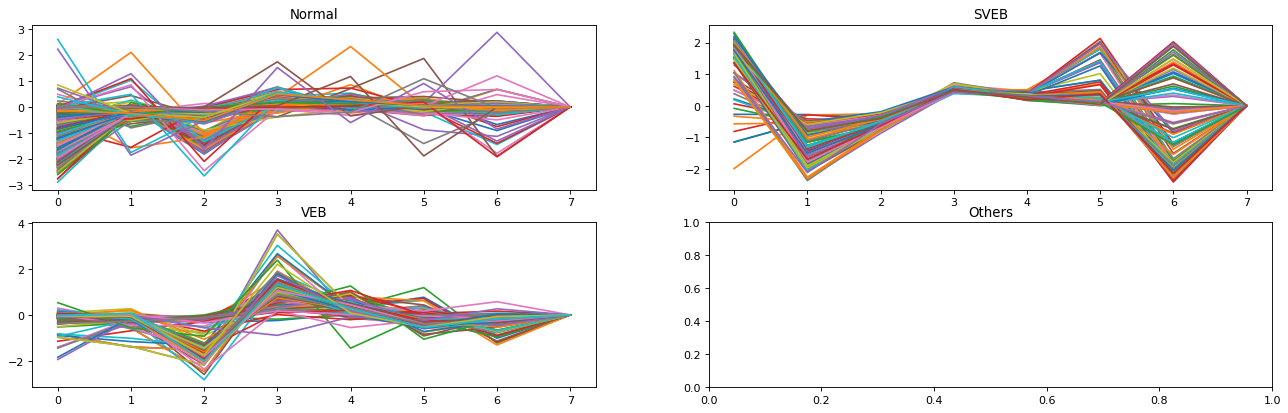

In [27]:
ds = '207'

featureCols = list(Refined_Hbs_lead0[ds]['cD5'])

plt.figure(figsize=(20, 6), dpi=80)
p1 = plt.subplot(221)
p1.set_title('Normal')
p2 = plt.subplot(222)
p2.set_title('SVEB')
p3 = plt.subplot(223)
p3.set_title('VEB')
p4 = plt.subplot(224)
p4.set_title('Others')

for i, feature in enumerate(featureCols):
    if Refined_Hbs_lead0[ds]['ann'][i] in N:
        p1.plot(featureCols[i])
    elif Refined_Hbs_lead0[ds]['ann'][i] in SVEB:
        p2.plot(featureCols[i])
    elif Refined_Hbs_lead0[ds]['ann'][i] in VEB:
        p3.plot(featureCols[i])
    else:
        p4.plot(featureCols[i])

plt.show()